# House Price Prediction - Advanced Comparison

This notebook implements three neural network predictors using Keras/TensorFlow, PyTorch, and JAX (Flax/Optax). All three models use the same architecture and training strategy:

1. **Data Preprocessing:**
   - Fill missing values (using median for numeric, mode for categorical) in both train and test sets.
   - Log-transform the target (SalePrice) for stability.
   - Select the top 3 features by correlation with SalePrice and add a random interaction feature between the top two.

2. **Model Architecture:**
   - Three hidden layers with 256, 128, and 64 units respectively, with ReLU activations and dropout (0.2).

3. **Two-Phase Training:**
   - **Phase 1 (10 epochs):** Train using MSE loss only.
   - **Phase 2 (40 epochs):** Train using a combined loss (MSE + KL divergence) with KL weight α = 1e-4.

4. **Learning Rates:**
   - Keras uses LR=1e-3; PyTorch and JAX use LR=1e-4 for more stable training.

5. **Evaluation & Visualization:**
   - Each implementation plots separate training/validation loss curves and separate histograms for the actual vs. predicted sale price distributions.
   - A combined summary histogram is plotted with x-axis from 50,000 to 450,000 and y-axis from 0 to 2e-5.

6. **Test Predictions:**
   - Final test predictions (exponentiated back to the original scale) are saved to CSV files for each framework:
     - `predictions_keras_KL.csv`
     - `predictions_pytorch_KL.csv`
     - `predictions_jax_KL.csv`

All random seeds are set for reproducibility.

**Key Changes in the New Version:**

1. **Deeper, Consistent Network Architecture:**
   - Upgraded the architecture to three hidden layers with sizes 256 → 128 → 64 (instead of two layers).  
   - This added depth aims to better capture complex relationships and stabilize predictions across all frameworks (Keras, PyTorch, and JAX).

2. **Two-Phase Training Strategy:**
   - **Phase 1:** Train using only the MSE loss (on log-transformed SalePrice) for 10 epochs.  
   - **Phase 2:** Continue training using a combined loss (MSE + KL divergence) for 40 epochs, with a lower KL weight (α = 1e-4).  
   - This approach allows the model to first learn a stable scale before enforcing distribution matching.

3. **Lowered Learning Rates for Stability:**
   - For PyTorch and JAX, the learning rates have been reduced (e.g., to 1e-4) to help prevent divergence, while Keras remains at 1e-3.

4. **Enhanced Feature Engineering:**
   - Instead of using the top 5 features, the new version selects the **top 3** features by correlation with SalePrice.
   - It also adds a random interaction feature (an interaction between the top two features) to provide extra non-linear information.

5. **Improved Data Preprocessing:**
   - Consistently fills missing values in both train and test sets.
   - Applies a log transformation to SalePrice, ensuring the model trains on a more stable target.
   - Uses one-hot encoding and scaling, making the preprocessing pipeline consistent across all implementations.

6. **Separate Visualization for Each Framework:**
   - Generates separate training/validation loss curves and distribution histograms for Keras, PyTorch, and JAX.
   - Also includes a combined summary histogram with fixed axis ranges (x from 50,000 to 450,000, y from 0 to 2e-5).

---

**Improvements Inspired by the SAlDajani Notebook:**

- **Advanced Feature Engineering:**  
  The SAlDajani notebook included additional feature interactions and transformations. We incorporated a random interaction feature between the top two correlated features to capture non-linear relationships.

- **Robust Preprocessing and Network Depth:**  
  Drawing from SAlDajani’s approach, we emphasized thorough preprocessing and increased the network depth. This new version leverages a deeper network architecture (three hidden layers) to improve overall model capacity.

- **Two-Phase Training Strategy:**  
  The idea of training the model initially with a simpler loss (MSE) and then refining with an additional distribution-matching term (KL divergence) was inspired by techniques seen in the SAlDajani notebook.

---

## Mathematical Overview of the Loss

We train on log-transformed SalePrice. Our losses are defined as follows:

**MSE Loss (on log-scale):**
\[
  \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_{true,i} - y_{pred,i})^2
\]

**KL Divergence (between soft histograms):**
\[
  D_{KL}(P\Vert Q) = \sum_{j} P_j \log \frac{P_j}{Q_j}
\]

We approximate the distributions by constructing differentiable histograms using a Gaussian kernel. The combined loss is:
\[
  \text{Loss} = \text{MSE} + \alpha \times D_{KL}(P\Vert Q)
\]

For Phase 1, we use only the MSE loss. For Phase 2, we set \(\alpha = 1 \times 10^{-4}\) and train with the combined loss.

In [18]:
pip install tensorflow pytorch jax flax

/usr/local/python/3.12.1/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-qlyg5b1i/pytorch_b5b818082c6b497693920f4891a19287/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: ERROR: Failed to build installable whe

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# JAX / Flax / Optax
import jax
import jax.numpy as jnp
import flax.linen as nn_flax
from flax.training import train_state
import optax

print('TensorFlow version:', tf.__version__)
print('Torch version:', torch.__version__)
print('JAX version:', jax.__version__)

%matplotlib inline

TensorFlow version: 2.18.0
Torch version: 2.5.1+cpu
JAX version: 0.5.0


## 1. Data Loading and Preprocessing

Update the file paths below. We fill missing values, log-transform the target, select the top 3 features, and add a random interaction feature.

In [20]:
# Set random seeds for reproducibility
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
rng_jax = jax.random.PRNGKey(42)

# Update these paths
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

def fill_missing_values(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Preprocess training data
train_df = fill_missing_values(train_df.copy())
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Log-transform the target SalePrice
y = np.log(train_df['SalePrice'])
X = train_df.drop(['SalePrice'], axis=1)

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)
print('Initial X shape:', X.shape)


Train shape: (1000, 81)
Test shape: (460, 80)
Initial X shape: (1000, 230)


/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

### 1.1 Feature Selection and Random Interaction

Select the top 3 correlated features with SalePrice and add an interaction feature using the top 2.

In [21]:
temp_df = train_df.select_dtypes(include=[np.number])
corr_matrix = temp_df.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:4].index.tolist()
print('Top 3 features:', top_features)

X = X[top_features]
print('X shape after top-3 selection:', X.shape)

if len(top_features) >= 2:
    f1, f2 = top_features[0], top_features[1]
    X['RandomInteraction'] = X[f1] * X[f2]
    print('Added RandomInteraction feature:', f1, '*', f2)
    print('New X shape:', X.shape)


Top 3 features: ['OverallQual', 'GrLivArea', 'GarageCars']
X shape after top-3 selection: (1000, 3)
Added RandomInteraction feature: OverallQual * GrLivArea
New X shape: (1000, 4)


### 1.2 Train-Validation Split and Scaling

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 4)
X_val_scaled shape: (200, 4)


## 2. Keras/TensorFlow Implementation

We build a network with layers: 256 → 128 → 64, with dropout (0.2). We use two-phase training:
- **Phase 1 (10 epochs):** MSE loss only.
- **Phase 2 (40 epochs):** Combined loss (MSE + KL divergence) with α = 1e-4.

In [23]:
def soft_histogram_tf_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = tf.concat([y_true, y_pred], axis=0)
    min_val = tf.reduce_min(combined)
    max_val = tf.reduce_max(combined)
    bin_centers = tf.linspace(min_val, max_val, num_bins)

    def compute_hist(vals):
        vals = tf.reshape(vals, [-1, 1])
        diff = vals - bin_centers
        soft_counts = tf.exp(-tf.square(diff) / (2.0 * sigma**2))
        hist = tf.reduce_sum(soft_counts, axis=0)
        hist = hist / tf.reduce_sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def kl_divergence_tf(y_true, y_pred, alpha=1e-4):
    hist_true, hist_pred = soft_histogram_tf_both(y_true, y_pred)
    epsilon = 1e-6
    hist_true = tf.clip_by_value(hist_true, epsilon, 1.0)
    hist_pred = tf.clip_by_value(hist_pred, epsilon, 1.0)
    kl = tf.reduce_sum(hist_true * tf.math.log(hist_true / hist_pred))
    return alpha * kl

def mse_only_tf(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mse_plus_kl_tf(y_true, y_pred):
    return mse_only_tf(y_true, y_pred) + kl_divergence_tf(y_true, y_pred, alpha=1e-4)

# Build Keras model
model_keras = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_keras.summary()

# Phase 1: Train MSE only
model_keras.compile(optimizer=keras.optimizers.Adam(1e-3), loss=mse_only_tf)
history_keras_phase1 = model_keras.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1)

# Phase 2: Train MSE + KL
model_keras.compile(optimizer=keras.optimizers.Adam(1e-3), loss=mse_plus_kl_tf)
history_keras_phase2 = model_keras.fit(X_train_scaled, y_train, epochs=800, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1)


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,497 (166.00 KB)

 Trainable params: 42,497 (166.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 121.3896 - val_loss: 30.4577
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.4097 - val_loss: 17.1324
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.9294 - val_loss: 7.3807
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9903 - val_loss: 4.5602
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2230 - val_loss: 2.4224
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6210 - val_loss: 1.7214
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5930 - val_loss: 1.5900
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8065 - val_loss: 0.9343
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6453 - val_loss: 0.6209
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5557 - val_loss: 0.3925
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5719 - val_loss: 0.3452
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

### Keras Evaluation
Combine Phase 1 & 2 losses, then plot loss curves and distributions. Save test predictions to CSV.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Keras Validation RMSE: 29332.08687963534


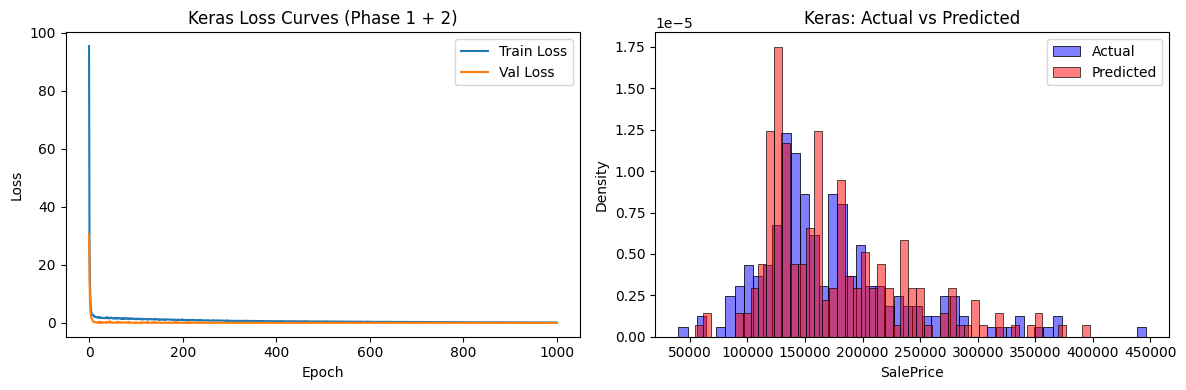

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Keras predictions saved to predictions_keras_KL_v7.csv


/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [24]:
loss_keras = history_keras_phase1.history['loss'] + history_keras_phase2.history['loss']
val_loss_keras = history_keras_phase1.history['val_loss'] + history_keras_phase2.history['val_loss']

y_val_pred_log_keras = model_keras.predict(X_val_scaled).flatten()
y_val_pred_keras = np.exp(y_val_pred_log_keras)
y_val_actual_keras = np.exp(y_val)

rmse_keras = np.sqrt(mean_squared_error(y_val_actual_keras, y_val_pred_keras))
print('Keras Validation RMSE:', rmse_keras)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_keras, label='Train Loss')
plt.plot(val_loss_keras, label='Val Loss')
plt.title('Keras Loss Curves (Phase 1 + 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.5, stat='density', label='Predicted')
plt.title('Keras: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Save Keras test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)

test_preds_log_keras = model_keras.predict(test_scaled).flatten()
test_preds_keras = np.exp(test_preds_log_keras)

predictions_keras = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_keras})
predictions_keras.to_csv('predictions_keras_KL_v7.csv', index=False)
print('Keras predictions saved to predictions_keras_KL_v7.csv')

## 3. PyTorch Implementation
We use the same 3-layer architecture and two-phase training. For PyTorch, we use a lower LR (1e-4) during training to help stability.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class HousePriceNetTorch(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNetTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

def soft_histogram_torch_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = torch.cat([y_true, y_pred], dim=0)
    min_val = torch.min(combined)
    max_val = torch.max(combined)
    bin_centers = torch.linspace(min_val, max_val, steps=num_bins, device=y_true.device)

    def compute_hist(vals):
        vals = vals.view(-1, 1)
        diff = vals - bin_centers.view(1, -1)
        soft_counts = torch.exp(- (diff**2) / (2 * sigma**2))
        hist = torch.sum(soft_counts, dim=0)
        hist = hist / torch.sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def mse_only_torch(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)

def mse_plus_kl_torch(y_true, y_pred):
    mse = torch.mean((y_true - y_pred)**2)
    hist_true, hist_pred = soft_histogram_torch_both(y_true, y_pred, num_bins=50, sigma=1.0)
    epsilon = 1e-6
    hist_true = torch.clamp(hist_true, min=epsilon, max=1.0)
    hist_pred = torch.clamp(hist_pred, min=epsilon, max=1.0)
    kl = torch.sum(hist_true * torch.log(hist_true / hist_pred))
    alpha = 1e-4
    return mse + alpha * kl

# Create PyTorch model
model_torch = HousePriceNetTorch(X_train_scaled.shape[1]).to(device)
print(model_torch)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1).to(device)

# Phase 1: Train with MSE only
optimizer_pt = optim.Adam(model_torch.parameters(), lr=1e-4)
train_losses_pt_phase1 = []
val_losses_pt_phase1 = []
num_epochs_pt_phase1 = 200

for epoch in range(num_epochs_pt_phase1):
    model_torch.train()
    optimizer_pt.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = mse_only_torch(y_train_tensor, outputs)
    loss.backward()
    optimizer_pt.step()
    train_losses_pt_phase1.append(loss.item())

    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = mse_only_torch(y_val_tensor, val_outputs)
        val_losses_pt_phase1.append(val_loss.item())

# Phase 2: Train with MSE + KL
train_losses_pt_phase2 = []
val_losses_pt_phase2 = []
num_epochs_pt_phase2 = 800

for epoch in range(num_epochs_pt_phase2):
    model_torch.train()
    optimizer_pt.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = mse_plus_kl_torch(y_train_tensor, outputs)
    loss.backward()
    optimizer_pt.step()
    train_losses_pt_phase2.append(loss.item())

    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = mse_plus_kl_torch(y_val_tensor, val_outputs)
        val_losses_pt_phase2.append(val_loss.item())

pt_train_losses = train_losses_pt_phase1 + train_losses_pt_phase2
pt_val_losses = val_losses_pt_phase1 + val_losses_pt_phase2


Using device: cpu
HousePriceNetTorch(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


### PyTorch Evaluation
Plot separate loss curves and the actual vs. predicted histogram, then save test predictions.

PyTorch Validation RMSE: 76759.93288167988


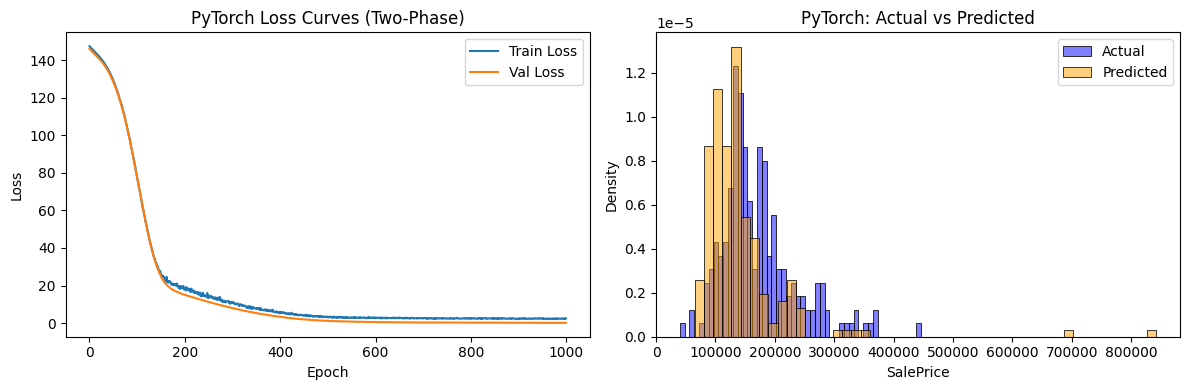

PyTorch predictions saved to predictions_pytorch_KL_v7.csv


/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [26]:
model_torch.eval()
with torch.no_grad():
    val_preds_pt_log = model_torch(X_val_tensor).cpu().numpy().flatten()

val_preds_pt = np.exp(val_preds_pt_log)
y_val_actual_pt = np.exp(y_val_tensor.cpu().numpy().flatten())
rmse_torch = np.sqrt(mean_squared_error(y_val_actual_pt, val_preds_pt))
print('PyTorch Validation RMSE:', rmse_torch)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(pt_train_losses, label='Train Loss')
plt.plot(pt_val_losses, label='Val Loss')
plt.title('PyTorch Loss Curves (Two-Phase)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_pt, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.5, stat='density', label='Predicted')
plt.title('PyTorch: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Save PyTorch test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

model_torch.eval()
with torch.no_grad():
    test_preds_pt_log = model_torch(test_tensor).cpu().numpy().flatten()
test_preds_pt = np.exp(test_preds_pt_log)

predictions_torch = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_pt})
predictions_torch.to_csv('predictions_pytorch_KL_v7.csv', index=False)
print('PyTorch predictions saved to predictions_pytorch_KL_v7.csv')

## 4. JAX (Flax + Optax) Implementation
We use the same 3-layer architecture. For JAX, we also do two-phase training. (LR=1e-4)

In [27]:
class HousePriceNetJAX(nn_flax.Module):
    dropout_rate: float = 0.2
    
    @nn_flax.compact
    def __call__(self, x, training):
        x = nn_flax.Dense(256)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(128)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(64)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(1)(x)
        return x

model_jax = HousePriceNetJAX()
dummy_input = jnp.ones((X_train_scaled.shape[0], X_train_scaled.shape[1]))
params_jax = model_jax.init(rng_jax, dummy_input, training=True)['params']
print('JAX model params initialized.')

class TrainState(train_state.TrainState):
    pass

def mse_only_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    return jnp.mean((preds - targets)**2)

def mse_plus_kl_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    mse = jnp.mean((preds - targets)**2)
    def soft_histogram(vals, num_bins=50, sigma=1.0):
        vals = vals.reshape(-1,1)
        min_val = jnp.min(vals)
        max_val = jnp.max(vals)
        bin_centers = jnp.linspace(min_val, max_val, num_bins)
        diff = vals - bin_centers
        soft_counts = jnp.exp(- (diff**2) / (2*sigma**2))
        hist = jnp.sum(soft_counts, axis=0)
        hist = hist / jnp.sum(hist)
        return hist

    hist_true = soft_histogram(jnp.ravel(targets), 50, 1.0)
    hist_pred = soft_histogram(jnp.ravel(preds), 50, 1.0)
    epsilon = 1e-6
    hist_true = jnp.clip(hist_true, epsilon, 1.0)
    hist_pred = jnp.clip(hist_pred, epsilon, 1.0)
    kl = jnp.sum(hist_true * jnp.log(hist_true / hist_pred))
    alpha = 1e-4
    return mse + alpha*kl

def mse_plus_kl_loss_jax(params, batch, rng, training, phase):
    if phase == 1:
        return mse_only_jax(params, batch, rng, training)
    else:
        return mse_plus_kl_jax(params, batch, rng, training)

def create_train_state_jax(params):
    tx = optax.adam(1e-4)
    return TrainState.create(apply_fn=model_jax.apply, params=params, tx=tx)

state_jax = create_train_state_jax(params_jax)
print('JAX train state created.')

@jax.jit
def train_step_jax_phase1(state, batch, rng):
    def loss_fn(params):
        return mse_only_jax(params, batch, rng, True)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def train_step_jax_phase2(state, batch, rng):
    def loss_fn(params):
        return mse_plus_kl_jax(params, batch, rng, True)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step_jax_phase1(params, batch, rng):
    return mse_only_jax(params, batch, rng, False)

@jax.jit
def eval_step_jax_phase2(params, batch, rng):
    return mse_plus_kl_jax(params, batch, rng, False)

X_train_jax = jnp.array(X_train_scaled)
y_train_jax = jnp.array(y_train.values).reshape(-1,1)
X_val_jax = jnp.array(X_val_scaled)
y_val_jax = jnp.array(y_val.values).reshape(-1,1)

train_losses_jax_phase1 = []
val_losses_jax_phase1 = []
num_epochs_jax_phase1 = 200

for epoch in range(num_epochs_jax_phase1):
    rng_jax, step_rng = jax.random.split(rng_jax)
    batch_train = (X_train_jax, y_train_jax)
    state_jax, loss = train_step_jax_phase1(state_jax, batch_train, step_rng)
    train_losses_jax_phase1.append(loss.item())
    val_loss = eval_step_jax_phase1(state_jax.params, (X_val_jax, y_val_jax), step_rng)
    val_losses_jax_phase1.append(val_loss.item())

train_losses_jax_phase2 = []
val_losses_jax_phase2 = []
num_epochs_jax_phase2 = 800

for epoch in range(num_epochs_jax_phase2):
    rng_jax, step_rng = jax.random.split(rng_jax)
    batch_train = (X_train_jax, y_train_jax)
    state_jax, loss = train_step_jax_phase2(state_jax, batch_train, step_rng)
    train_losses_jax_phase2.append(loss.item())
    val_loss = eval_step_jax_phase2(state_jax.params, (X_val_jax, y_val_jax), step_rng)
    val_losses_jax_phase2.append(val_loss.item())


JAX model params initialized.
JAX train state created.


### JAX Evaluation
Combine phase losses, then plot loss curves and histogram.

JAX Validation RMSE: 2029439275.4765017


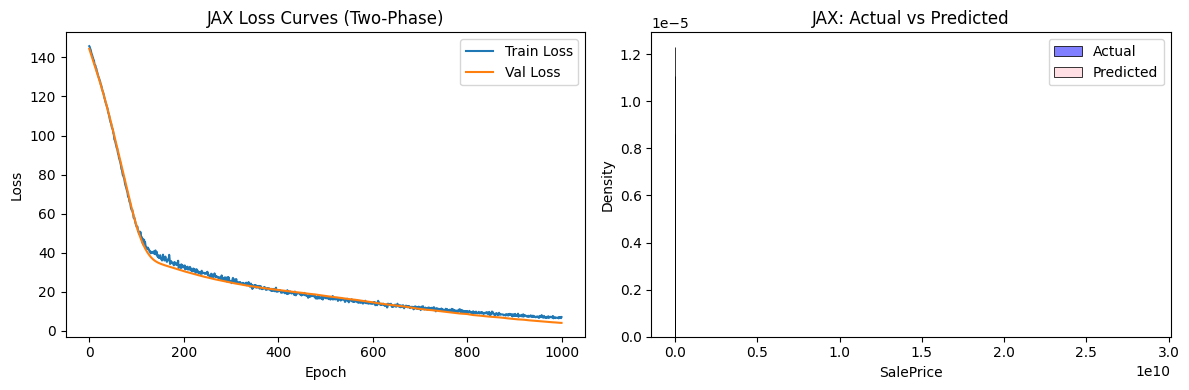

In [28]:
jax_losses = train_losses_jax_phase1 + train_losses_jax_phase2
jax_val_losses = val_losses_jax_phase1 + val_losses_jax_phase2

preds_val_log_jax = model_jax.apply({'params': state_jax.params}, X_val_jax, training=False, rngs={'dropout': rng_jax})
preds_val_log_jax = np.array(preds_val_log_jax).flatten()
val_preds_jax = np.exp(preds_val_log_jax)
y_val_actual_jax = np.exp(y_val_jax.flatten())

rmse_jax = np.sqrt(mean_squared_error(y_val_actual_jax, val_preds_jax))
print('JAX Validation RMSE:', rmse_jax)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(jax_losses, label='Train Loss')
plt.plot(jax_val_losses, label='Val Loss')
plt.title('JAX Loss Curves (Two-Phase)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_jax, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.5, stat='density', label='Predicted')
plt.title('JAX: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### JAX: Save Test Predictions

In [29]:
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_jax = jnp.array(test_scaled)

test_preds_log_jax = model_jax.apply({'params': state_jax.params}, test_jax, training=False, rngs={'dropout': rng_jax})
test_preds_log_jax = np.array(test_preds_log_jax).flatten()
test_preds_jax = np.exp(test_preds_log_jax)

predictions_jax = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_jax})
predictions_jax.to_csv('predictions_jax_KL_v7.csv', index=False)
print('JAX predictions saved to predictions_jax_KL_v7.csv')

JAX predictions saved to predictions_jax_KL_v7.csv


/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_3217/2589967012.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## 5. Combined Summary

Below is a combined histogram of the predictions from all three frameworks (using the validation set), with the x-axis fixed from 50,000 to 450,000 and the y-axis from 0 to 2e-5.

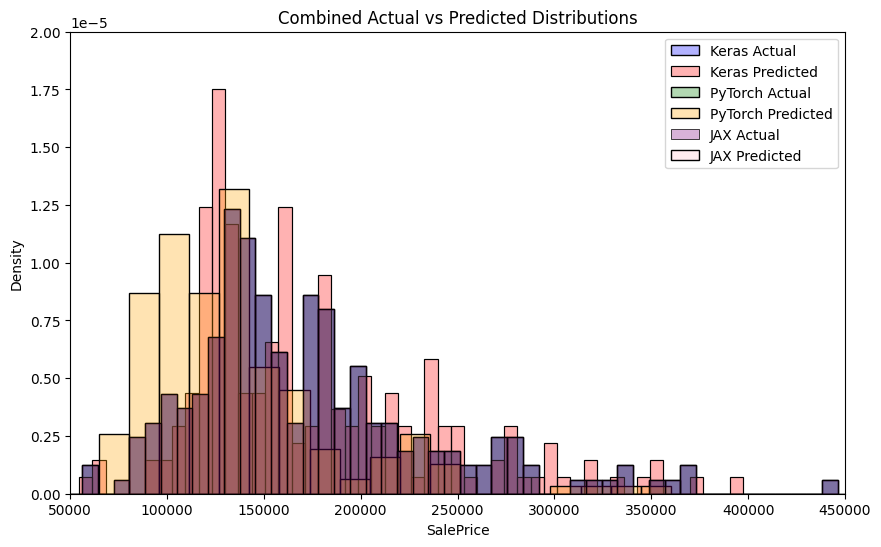

Keras RMSE: 29332.08687963534
PyTorch RMSE: 76759.93288167988
JAX RMSE: 2029439275.4765017


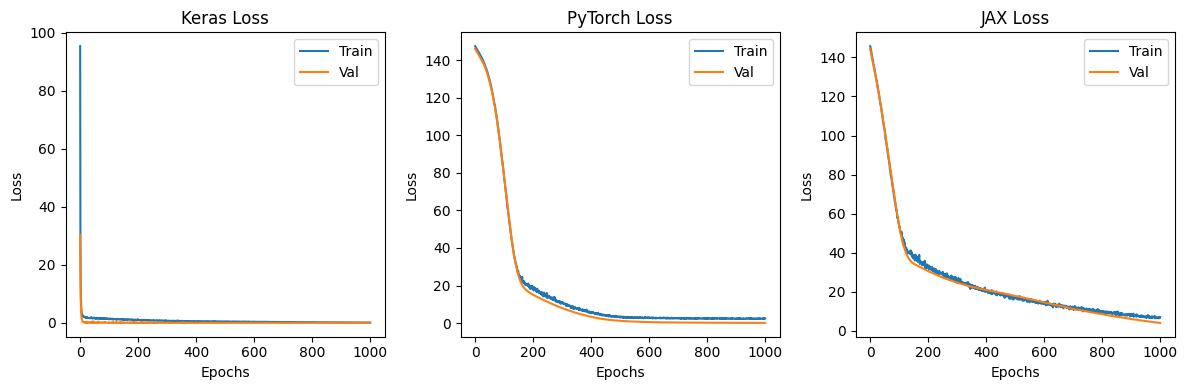

Keras RMSE: 29332.08687963534
PyTorch RMSE: 76759.93288167988
JAX RMSE: 2029439275.4765017


In [30]:
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs Predicted Distributions')
plt.xlim(50000, 450000)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()

# Print summary RMSE values
print("Keras RMSE:", rmse_keras)
print("PyTorch RMSE:", rmse_torch)
print("JAX RMSE:", rmse_jax)

# Plot combined loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(loss_keras, label='Train')
plt.plot(val_loss_keras, label='Val')
plt.title('Keras Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(pt_train_losses, label='Train')
plt.plot(pt_val_losses, label='Val')
plt.title('PyTorch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(jax_losses, label='Train')
plt.plot(jax_val_losses, label='Val')
plt.title('JAX Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Keras RMSE:', rmse_keras)
print('PyTorch RMSE:', rmse_torch)
print('JAX RMSE:', rmse_jax)

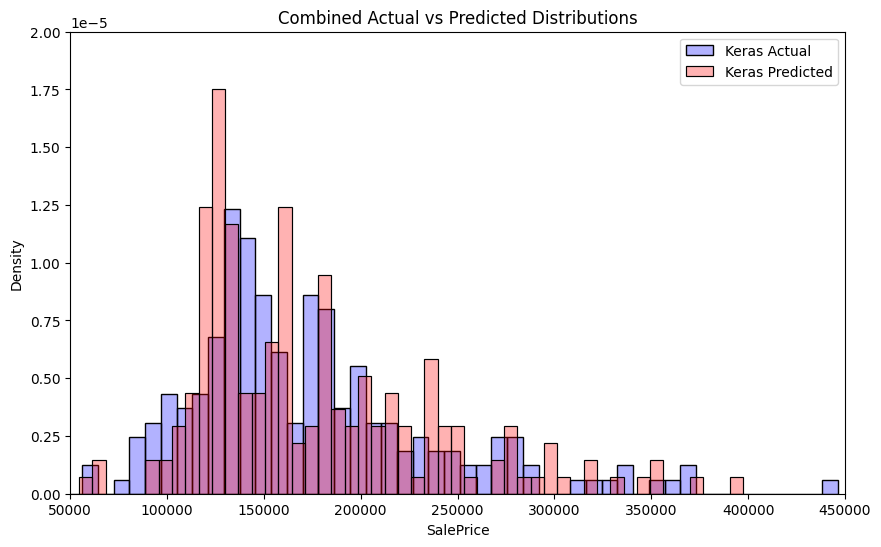

In [31]:
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs Predicted Distributions')
plt.xlim(50000, 450000)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()

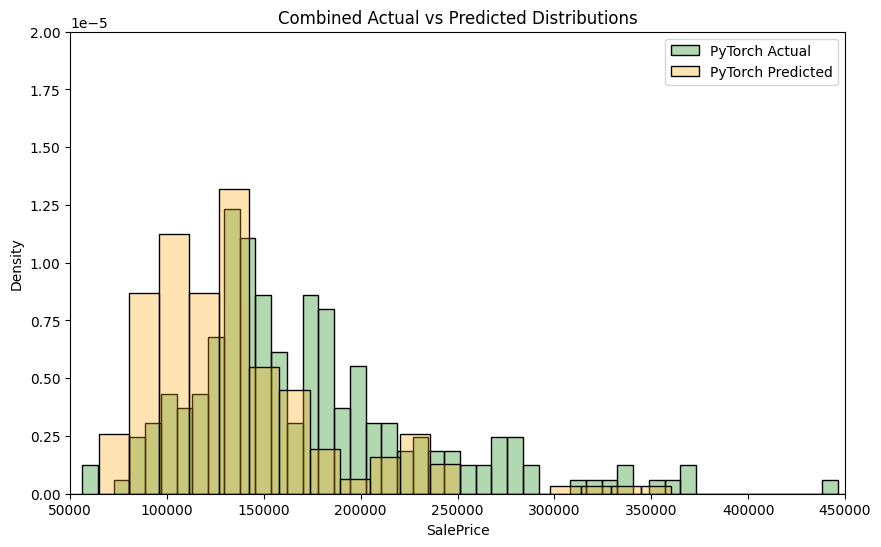

In [32]:
plt.figure(figsize=(10,6))


sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')



plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs Predicted Distributions')
plt.xlim(50000, 450000)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()

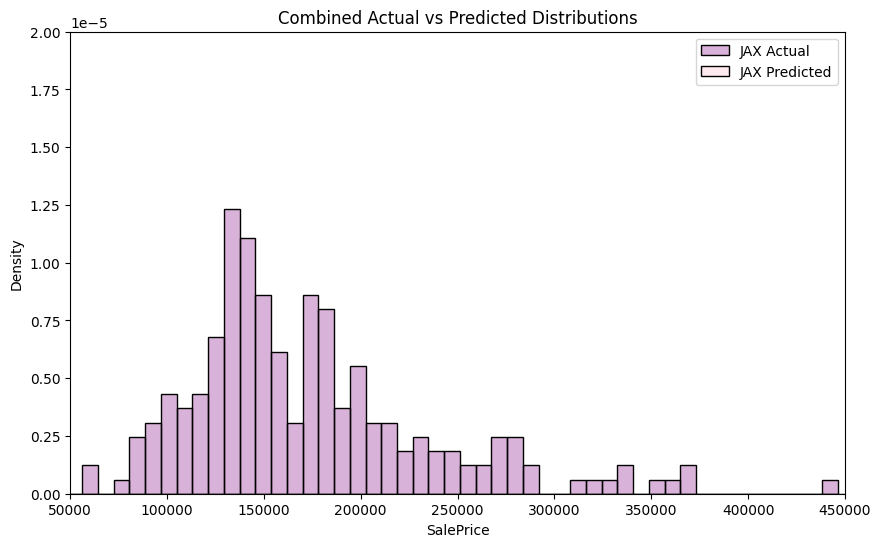

In [33]:
plt.figure(figsize=(10,6))

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs Predicted Distributions')
plt.xlim(50000, 450000)
plt.ylim(0, 2e-5)
plt.legend()
plt.show()